In [8]:
!pip install spotipy

In [9]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [10]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
#from diversify.session import SpotifySession

In [11]:

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='88d5f9f8717f4ddcae5b8eb5b7e66581',
                                                           client_secret='f9cee08b9abd4b5b87cba994229eeb73'))

In [12]:
# we will need more songs for our clustering
#this is the playlist of previous cohorts
playlist = sp.user_playlist_tracks("spotify", "0BUNSGihi2mrhQu3fPcVim")

In [13]:
playlist.keys()

dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

In [14]:
# checking the track names from playlist
playlist["items"][0]["track"]["name"]

'Rainbow Connection'

In [15]:
#''' What we need:
# 1) Get Playlist [x]
# 2) Get artist name from each song of the playlist
# 3) Get all albums from each of the artists
# 4) Get all songs from each of the albums
 #5) Get URI's for all the songs


In [16]:
# we will need more songs for our clustering
#this is the playlist of previous cohorts
playlist = sp.user_playlist_tracks("spotify", "0BUNSGihi2mrhQu3fPcVim")
 


In [17]:
playlist["total"] # total no of songs

815

In [18]:
# It is limited to 100 tracks, we will have to fix it:
len(playlist["items"])

100

In [19]:
playlist['next']

'https://api.spotify.com/v1/playlists/0BUNSGihi2mrhQu3fPcVim/tracks?offset=100&limit=100&additional_types=track'

In [20]:
playlist['next']

'https://api.spotify.com/v1/playlists/0BUNSGihi2mrhQu3fPcVim/tracks?offset=100&limit=100&additional_types=track'

In [21]:
#sp.next(playlist)

In [22]:
#  Importing all thes tracks from spotify api playlist
from random import randint
from time import sleep

def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3))
    return tracks

In [23]:
# this will take at least around num_songs_in_playlist * (avg_sleep_time + processing_time) = 53 * (2+0.1) = 110 seconds

all_tracks = get_playlist_tracks("0BUNSGihi2mrhQu3fPcVim")
len(all_tracks)

815

In [24]:
# getting all track uris 
def uri(all_tracks):
    uri=[all_tracks[i]['track']['uri'] for i in range(len(all_tracks))]
    return uri
all_uri = uri(all_tracks)

In [25]:
import pandas as pd
complete_all_uri = pd.DataFrame(all_uri, columns=['uri'])

In [26]:
complete_all_uri.shape

(815, 1)

In [27]:
# getting all artists
def artists(all_tracks):
    artist=[all_tracks[i]['track']['artists'][0]['name'] for i in range(len(all_tracks))]
    return artist
all_artists = artists(all_tracks)

In [28]:
complete_all_artists= pd.DataFrame(all_artists, columns=['artist'])
# complete_all_artists

In [29]:
# getting all track names
def track_names(all_tracks):
    names=[all_tracks[i]['track']['name'] for i in range(len(all_tracks))]
    return names
all_track_names = track_names(all_tracks)

In [30]:
complete_track_names= pd.DataFrame(all_track_names, columns=['album'])
# complete_track_names

In [31]:
# getting audio features for all the tracks
audio_features = [sp.audio_features(i) for i in (all_uri)]

In [32]:
def flatten(input_list):
    return [item for sublist in input_list for item in sublist]

In [33]:
# flattening audio features 
features_new = flatten(audio_features)

In [34]:
danceability = [features_new[i]['danceability'] for i in range(len(features_new))]
energy = [features_new[i]['energy'] for i in range(len(features_new))]
key = [features_new[i]['key'] for i in range(len(features_new))]
loudness = [features_new[i]['loudness'] for i in range(len(features_new))]
mode = [features_new[i]['mode'] for i in range(len(features_new))]
speechiness = [features_new[i]['speechiness'] for i in range(len(features_new))]
acousticness = [features_new[i]['acousticness'] for i in range(len(features_new))]
instrumentalness = [features_new[i]['instrumentalness'] for i in range(len(features_new))]
liveness = [features_new[i]['liveness'] for i in range(len(features_new))]
valence = [features_new[i]['valence'] for i in range(len(features_new))]
tempo = [features_new[i]['tempo'] for i in range(len(features_new))]

In [35]:
# audio features in a data frame
complete_features = pd.DataFrame.from_dict({'danceability':danceability, 'energy':energy, 'key':key, 'loudness':loudness, 'mode':mode, 'speechiness':speechiness, 'acousticness':acousticness, 'instrumentalness':instrumentalness, 'liveness':liveness, 'valence':valence, 'tempo':tempo})
# complete_features

In [36]:
complete_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.526,0.413,9,-7.674,1,0.0278,0.42800,0.000000,0.1260,0.211,115.936
1,0.663,0.168,0,-13.725,1,0.0448,0.92800,0.000057,0.3610,0.678,85.005
2,0.422,0.878,5,-4.863,1,0.0442,0.00935,0.332000,0.2010,0.496,84.044
3,0.821,0.676,3,-6.366,0,0.0547,0.18700,0.000100,0.0927,0.559,119.012
4,0.388,0.327,5,-12.522,1,0.0317,0.73200,0.001030,0.1500,0.222,107.894
...,...,...,...,...,...,...,...,...,...,...,...
810,0.569,0.367,5,-5.178,1,0.0878,0.86200,0.000155,0.3370,0.823,169.768
811,0.732,0.764,10,-6.503,0,0.0631,0.16200,0.346000,0.3220,0.685,132.019
812,0.308,0.376,4,-15.240,1,0.0626,0.11600,0.000003,0.1660,0.158,186.047
813,0.536,0.642,5,-6.479,0,0.0434,0.06400,0.356000,0.1050,0.193,138.914


In [37]:
# all top songs with audio features
all_top_songs =pd.concat([complete_track_names,complete_all_artists,complete_all_uri,complete_features], axis=1)
all_top_songs

,album,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Rainbow Connection,The Muppets,spotify:track:1SJ4ycWow4yz6z4oFz8NAG,0.526,0.413,9,-7.674,1,0.0278,0.42800,0.000000,0.1260,0.211,115.936
1,Somewhere Over The Rainbow_What A Wonderful World,Israel Kamakawiwo'ole,spotify:track:25U7raB3ZSszayTYClh4hF,0.663,0.168,0,-13.725,1,0.0448,0.92800,0.000057,0.3610,0.678,85.005
2,What a Wonderful World,Joey Ramone,spotify:track:04cdEVbQPb8BJb7593e5fO,0.422,0.878,5,-4.863,1,0.0442,0.00935,0.332000,0.2010,0.496,84.044
3,One Day / Reckoning Song (Wankelmut Remix) [Ra...,Asaf Avidan & the Mojos,spotify:track:5HSkycOEtb9iQ7cg1Oyqmu,0.821,0.676,3,-6.366,0,0.0547,0.18700,0.000100,0.0927,0.559,119.012
4,What A Wonderful World - Single Version,Louis Armstrong,spotify:track:2pp3RfqX5cb1BAnmNi4Nej,0.388,0.327,5,-12.522,1,0.0317,0.73200,0.001030,0.1500,0.222,107.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,The Loophole,Garfunkel and Oates,spotify:track:6B89ADIwxCw60PHZN6Kdp4,0.569,0.367,5,-5.178,1,0.0878,0.86200,0.000155,0.3370,0.823,169.768
811,Major Tom (Coming Home) - Adam K & Soha Radio ...,Shiny Toy Guns,spotify:track:7nXXIXFSyDDPlfzCW9bdAa,0.732,0.764,10,-6.503,0,0.0631,0.16200,0.346000,0.3220,0.685,132.019
812,The Wreck of the Edmund Fitzgerald,Gordon Lightfoot,spotify:track:536L9C0N7vhYdibCJx3cI2,0.308,0.376,4,-15.240,1,0.0626,0.11600,0.000003,0.1660,0.158,186.047
813,Fortune Soul,Blackmill,spotify:track:2eTjkXxxssJeR3u586CMkI,0.536,0.642,5,-6.479,0,0.0434,0.06400,0.356000,0.1050,0.193,138.914


In [38]:
# Saving files to csv format
#all_top_songs.to_csv('all_top_songs.csv', index=False)

In [39]:
#Songs to cluster
df_songs = pd.read_csv('all_top_songs.csv')
df_songs.head(3)

,album,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Rainbow Connection,The Muppets,spotify:track:1SJ4ycWow4yz6z4oFz8NAG,0.526,0.413,9,-7.674,1,0.0278,0.42800,0.000000,0.126,0.211,115.936
1,Somewhere Over The Rainbow_What A Wonderful World,Israel Kamakawiwo'ole,spotify:track:25U7raB3ZSszayTYClh4hF,0.663,0.168,0,-13.725,1,0.0448,0.92800,0.000057,0.361,0.678,85.005
2,What a Wonderful World,Joey Ramone,spotify:track:04cdEVbQPb8BJb7593e5fO,0.422,0.878,5,-4.863,1,0.0442,0.00935,0.332000,0.201,0.496,84.044


In [40]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album             815 non-null    object 
 1   artist            815 non-null    object 
 2   uri               815 non-null    object 
 3   danceability      815 non-null    float64
 4   energy            815 non-null    float64
 5   key               815 non-null    int64  
 6   loudness          815 non-null    float64
 7   mode              815 non-null    int64  
 8   speechiness       815 non-null    float64
 9   acousticness      815 non-null    float64
 10  instrumentalness  815 non-null    float64
 11  liveness          815 non-null    float64
 12  valence           815 non-null    float64
 13  tempo             815 non-null    float64
dtypes: float64(9), int64(2), object(3)
memory usage: 89.3+ KB


In [41]:
df_songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000
mean,0.548629,0.634118,5.076074,-7.885919,0.682209,0.060504,0.261070,0.053936,0.189893,0.500615,123.636579
std,0.155512,0.232019,3.505924,3.588865,0.465904,0.054374,0.292784,0.177651,0.161521,0.248240,29.468800
min,0.065900,0.030300,0.000000,-23.035000,0.000000,0.024300,0.000005,0.000000,0.021600,0.036900,59.965000
25%,0.447500,0.468500,2.000000,-9.979500,0.000000,0.032400,0.016900,0.000000,0.094100,0.305000,101.990500
50%,0.555000,0.663000,5.000000,-7.062000,1.000000,0.041700,0.125000,0.000008,0.124000,0.497000,122.873000
75%,0.663000,0.835000,8.000000,-5.225500,1.000000,0.062100,0.455000,0.001520,0.238500,0.711000,140.094500
max,0.940000,0.993000,11.000000,-1.108000,1.000000,0.505000,0.984000,0.934000,0.972000,0.974000,211.270000


In [42]:
df_songs.columns #Verifying columns

Index(['album', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [43]:
df_user = pd.read_csv('top_100_songs.csv') #Users songs
df_user.head(3)

,index,title,artist
0,0,love nwantiti (feat. Axel & DJ Yo) [Remix],CKay
1,1,Manike Mage Hithe,"Chamath Sangeeth, Yohani & Satheeshan"
2,2,Jugnu (feat. Nikhita Gandhi),Badshah


In [44]:
df_user.columns

Index(['index', 'title', 'artist'], dtype='object')

In [45]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   200 non-null    int64 
 1   title   200 non-null    object
 2   artist  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [46]:
df_user.describe()

,index
count,200.000000
mean,49.500000
std,28.938507
min,0.000000
25%,24.750000
50%,49.500000
75%,74.250000
max,99.000000


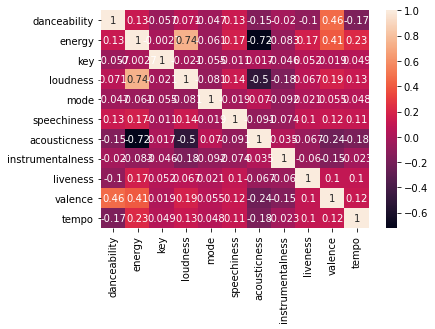

In [47]:
ax = sns.heatmap(df_songs.corr(), annot=True) #Verifying correlations between feature
plt.show()

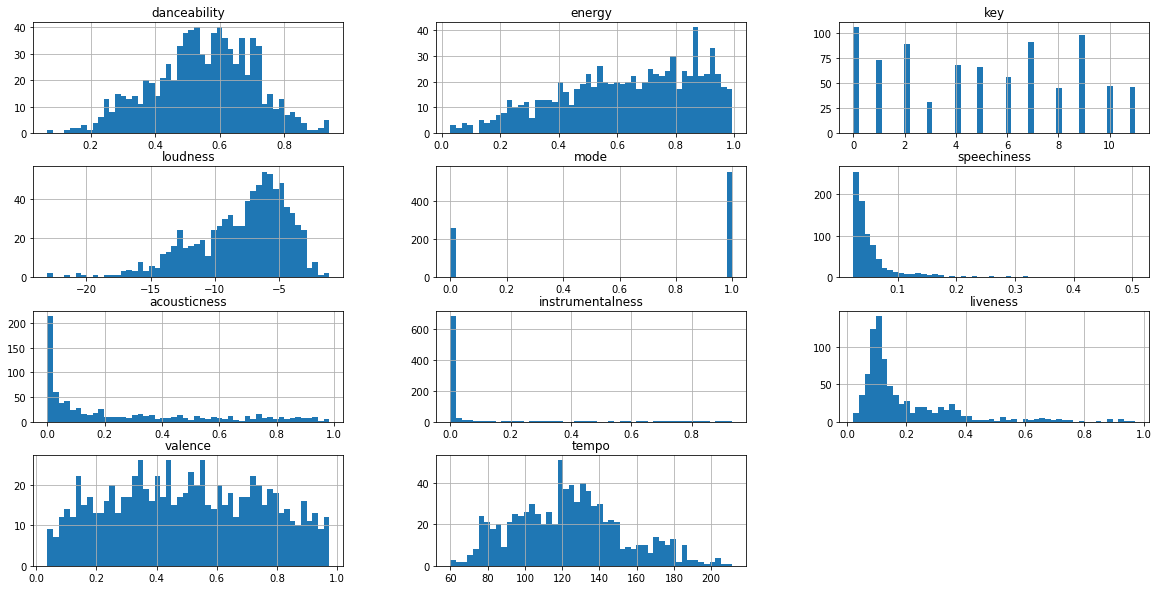

In [48]:
df_songs[['album', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']].hist(bins=50, figsize=(20,10))
plt.show() #Analyzing the distributions of the continuous features

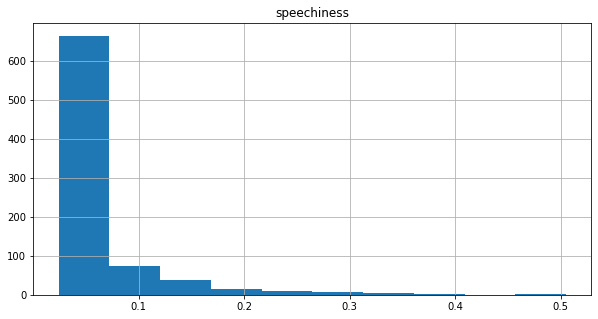

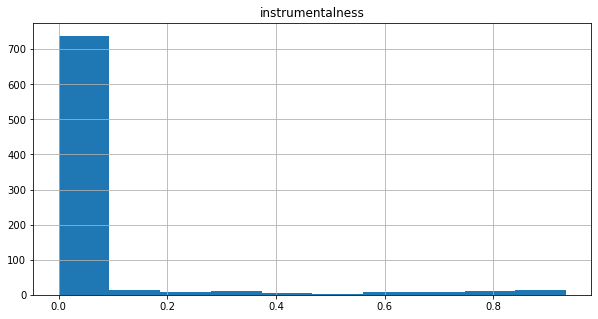

In [49]:
df_songs[['speechiness']].hist(figsize=(10,5))
df_songs[['instrumentalness']].hist(figsize=(10,5))
plt.show()

In [50]:
complete_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.526,0.413,9,-7.674,1,0.0278,0.42800,0.000000,0.1260,0.211,115.936
1,0.663,0.168,0,-13.725,1,0.0448,0.92800,0.000057,0.3610,0.678,85.005
2,0.422,0.878,5,-4.863,1,0.0442,0.00935,0.332000,0.2010,0.496,84.044
3,0.821,0.676,3,-6.366,0,0.0547,0.18700,0.000100,0.0927,0.559,119.012
4,0.388,0.327,5,-12.522,1,0.0317,0.73200,0.001030,0.1500,0.222,107.894
...,...,...,...,...,...,...,...,...,...,...,...
810,0.569,0.367,5,-5.178,1,0.0878,0.86200,0.000155,0.3370,0.823,169.768
811,0.732,0.764,10,-6.503,0,0.0631,0.16200,0.346000,0.3220,0.685,132.019
812,0.308,0.376,4,-15.240,1,0.0626,0.11600,0.000003,0.1660,0.158,186.047
813,0.536,0.642,5,-6.479,0,0.0434,0.06400,0.356000,0.1050,0.193,138.914


In [51]:
# Currently using MinMaxScaler
ss = StandardScaler()
scaler = ss.fit(complete_features)
scaled_data = scaler.transform(complete_features)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=1234)
kmeans.fit(scaled_data)




KMeans(n_clusters=3, random_state=1234)

In [52]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(scaled_data)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     42
1    488
2    285
dtype: int64

In [53]:
clusters

array([2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1,
       2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1,

In [54]:
#y.to_numpy()

In [55]:
kmeans.inertia_ 

6787.997962155754

In [56]:
kmeans_final = KMeans(n_clusters=7,
                init="random",
                n_init=30,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=10,
                tol=0,
                random_state=1234)
kmeans_final.fit(scaled_data)
print(kmeans_final.inertia_)

5078.904468539082


In [57]:
cluster = kmeans_final.predict(scaled_data)
cluster

array([1, 1, 6, 3, 1, 5, 6, 5, 2, 6, 0, 3, 3, 2, 3, 0, 3, 6, 1, 0, 1, 0,
       6, 3, 1, 1, 0, 6, 5, 6, 6, 1, 2, 1, 3, 1, 1, 2, 3, 6, 6, 6, 3, 2,
       3, 1, 6, 5, 0, 5, 2, 2, 1, 6, 3, 6, 0, 2, 3, 1, 5, 3, 6, 6, 3, 3,
       6, 6, 6, 5, 6, 4, 1, 6, 6, 5, 0, 6, 3, 1, 5, 3, 1, 5, 0, 1, 5, 6,
       0, 6, 6, 3, 6, 1, 1, 3, 3, 0, 0, 1, 3, 0, 3, 3, 3, 6, 1, 0, 3, 6,
       6, 3, 0, 3, 6, 3, 2, 2, 3, 1, 5, 0, 6, 2, 1, 6, 6, 3, 5, 5, 5, 6,
       1, 3, 6, 2, 6, 5, 5, 3, 1, 5, 6, 3, 1, 3, 1, 5, 6, 0, 6, 6, 6, 3,
       6, 3, 0, 0, 6, 3, 3, 3, 5, 6, 4, 6, 6, 6, 2, 6, 2, 6, 3, 6, 6, 1,
       1, 1, 5, 1, 3, 1, 6, 0, 4, 3, 3, 6, 6, 6, 6, 0, 6, 6, 1, 5, 1, 6,
       1, 6, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 1, 0, 3, 1, 0, 3, 6,
       6, 6, 2, 5, 6, 3, 6, 6, 1, 3, 6, 3, 6, 0, 3, 3, 6, 3, 4, 2, 6, 6,
       0, 3, 0, 6, 3, 6, 6, 1, 6, 1, 6, 0, 6, 6, 0, 6, 3, 5, 3, 6, 6, 0,
       3, 1, 0, 5, 6, 3, 3, 0, 6, 3, 3, 6, 6, 6, 6, 6, 6, 0, 0, 5, 6, 3,
       0, 5, 3, 6, 1, 6, 5, 3, 3, 1, 0, 3, 6, 6, 6,

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

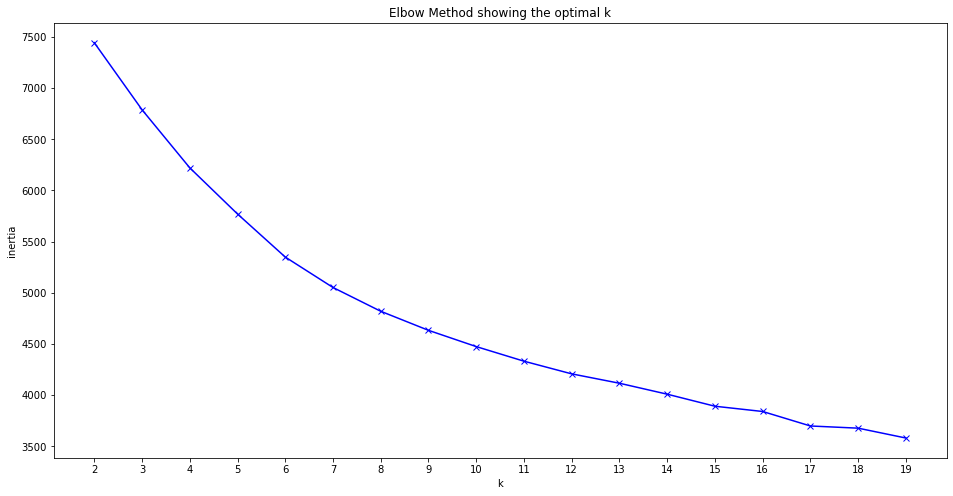

In [58]:
import numpy as np
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

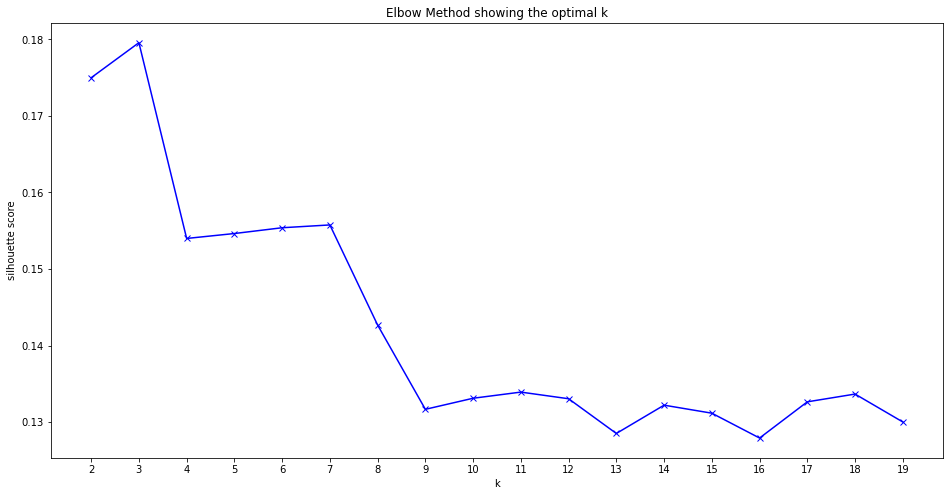

In [59]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(scaled_data)
    silhouette.append(silhouette_score(scaled_data, kmeans.predict(scaled_data)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [60]:
df_songs['new_cluster'] = cluster
df_songs['new_cluster']

0      1
1      1
2      6
3      3
4      1
      ..
810    0
811    3
812    0
813    3
814    4
Name: new_cluster, Length: 815, dtype: int32

In [61]:
df_songs.head()

,album,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,new_cluster
0,Rainbow Connection,The Muppets,spotify:track:1SJ4ycWow4yz6z4oFz8NAG,0.526,0.413,9,-7.674,1,0.0278,0.42800,0.000000,0.1260,0.211,115.936,1
1,Somewhere Over The Rainbow_What A Wonderful World,Israel Kamakawiwo'ole,spotify:track:25U7raB3ZSszayTYClh4hF,0.663,0.168,0,-13.725,1,0.0448,0.92800,0.000057,0.3610,0.678,85.005,1
2,What a Wonderful World,Joey Ramone,spotify:track:04cdEVbQPb8BJb7593e5fO,0.422,0.878,5,-4.863,1,0.0442,0.00935,0.332000,0.2010,0.496,84.044,6
3,One Day / Reckoning Song (Wankelmut Remix) [Ra...,Asaf Avidan & the Mojos,spotify:track:5HSkycOEtb9iQ7cg1Oyqmu,0.821,0.676,3,-6.366,0,0.0547,0.18700,0.000100,0.0927,0.559,119.012,3
4,What A Wonderful World - Single Version,Louis Armstrong,spotify:track:2pp3RfqX5cb1BAnmNi4Nej,0.388,0.327,5,-12.522,1,0.0317,0.73200,0.001030,0.1500,0.222,107.894,1


In [62]:
df_songs['new_cluster'].value_counts()

6    247
3    162
1    153
0    110
5     66
4     40
2     37
Name: new_cluster, dtype: int64

In [ ]:
df_songs.isna().sum().sum()

In [ ]:
df_songs.describe().T

In [110]:
pd.DataFrame(scaled_data).describe().T

,count,mean,std,min,25%,50%,75%,max
0,815.0,-1.919392e-16,1.000614,-3.106042,-0.650700,0.040991,0.735899,2.518210
1,815.0,2.702848e-16,1.000614,-2.604055,-0.714253,0.124557,0.866332,1.547730
2,815.0,1.280503e-16,1.000614,-1.448745,-0.877932,-0.021712,0.834508,1.690728
3,815.0,-2.383233e-16,1.000614,-4.223726,-0.583713,0.229717,0.741753,1.889756
4,815.0,1.155177e-16,1.000614,-1.465168,-1.465168,0.682515,0.682515,0.682515
5,815.0,1.404466e-16,1.000614,-0.666243,-0.517184,-0.346042,0.029365,8.179746
6,815.0,-5.626038e-17,1.000614,-0.892210,-0.834471,-0.465030,0.662772,2.470672
7,815.0,-1.460318e-16,1.000614,-0.303795,-0.303795,-0.303748,-0.295234,4.956938
8,815.0,1.560613e-16,1.000614,-1.042570,-0.593436,-0.408207,0.301115,4.845111
9,815.0,4.658850e-17,1.000614,-1.869157,-0.788491,-0.014571,0.848027,1.908136


### PCA

In [112]:
from sklearn.decomposition import PCA

In [113]:
pca = PCA()
pca.fit(scaled_data)

PCA()

In [114]:
pca.explained_variance_ratio_.round(2)

array([0.25, 0.13, 0.11, 0.1 , 0.09, 0.09, 0.08, 0.07, 0.04, 0.04, 0.01])

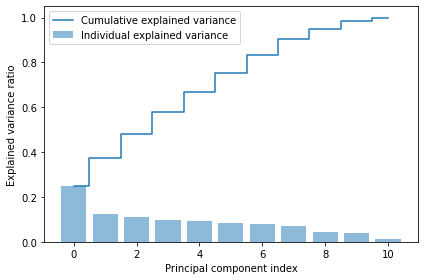

In [115]:
import numpy as np
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#cum_sum_eigenvalues

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [116]:
pca.explained_variance_ratio_[:14].sum()

0.9999999999999999

In [117]:
pca.explained_variance_ratio_[:7].sum()

0.8350130420303682

In [119]:
pca = PCA(7)
pca.fit(scaled_data)

PCA(n_components=7)

In [120]:
pca.explained_variance_ratio_.sum()

0.8350130420303689

### Audio features

In [64]:
# here we look only at the first page
playlist = sp.user_playlist_tracks("spotify", "0BUNSGihi2mrhQu3fPcVim")

In [65]:
playlist["items"][33]["track"]["name"]

'Role of A Lifetime'

In [66]:
# get the uri of a single song:
song_uri = playlist["items"][33]["track"]["uri"]

In [67]:
# get the audio features for that song
sp.audio_features(song_uri)

[{'danceability': 0.469,
  'energy': 0.212,
  'key': 2,
  'loudness': -12.13,
  'mode': 0,
  'speechiness': 0.0341,
  'acousticness': 0.652,
  'instrumentalness': 0.00113,
  'liveness': 0.104,
  'valence': 0.147,
  'tempo': 144.243,
  'type': 'audio_features',
  'id': '7DdkL7YtSRFZotD4qZloRG',
  'uri': 'spotify:track:7DdkL7YtSRFZotD4qZloRG',
  'track_href': 'https://api.spotify.com/v1/tracks/7DdkL7YtSRFZotD4qZloRG',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7DdkL7YtSRFZotD4qZloRG',
  'duration_ms': 213020,
  'time_signature': 3}]

In [68]:
# get the uri of a single song:
song_uri = playlist["items"][46]["track"]["uri"]

In [69]:
# get the audio features for that song
sp.audio_features(song_uri)

[{'danceability': 0.695,
  'energy': 0.869,
  'key': 8,
  'loudness': -5.066,
  'mode': 1,
  'speechiness': 0.0483,
  'acousticness': 0.41,
  'instrumentalness': 0,
  'liveness': 0.237,
  'valence': 0.58,
  'tempo': 124.989,
  'type': 'audio_features',
  'id': '05SBRd4fXgn8FX7bf8BCAE',
  'uri': 'spotify:track:05SBRd4fXgn8FX7bf8BCAE',
  'track_href': 'https://api.spotify.com/v1/tracks/05SBRd4fXgn8FX7bf8BCAE',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/05SBRd4fXgn8FX7bf8BCAE',
  'duration_ms': 234507,
  'time_signature': 4}]

In [70]:
def uris(all_tracks):
    uris = [all_tracks[i]['track']['uri'] for i in range(len(all_tracks))]
    return uris
uris = uris(all_tracks)

In [72]:
def all_artists(all_tracks):
    artist = [all_tracks[i]['track']['artists'][0]['name'] for i in range(len(all_tracks))]
    return artist